In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm, trange

In [ ]:
start_date = '2005-01-01'
end_date = '2023-12-12'
if_max = False
actions = True
stock_list = ['GOOG', 'AMZN', 'JPM', 'GME', 'XOM', 'SPY']
period = 40
train_rate = 0.8
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Return']
look_back = 80
input_size = len(features)
hidden_layer_size = 128
output_size = 1
epochs = 100
learning_rate = 0.001

In [ ]:
# load stock price data
def get_stock_price(stock, if_max=False, start='2022-01-01', end='2023-01-01'):
    if if_max:
        return yf.download(stock, period='max', actions=True)
    else:
        return yf.download(stock, start=start, end=end, actions=True)


def normalization(stock_df):
    for column in stock_df.columns:
        stock_df[column] = (stock_df[column] - stock_df[column].mean()) / stock_df[column].std()
    return stock_df


# check if there is any NA value
def check_na_value(stock_dict):
    for stock in stock_dict.keys():
        if len(stock_dict[stock]) != len(stock_dict[stock].dropna()):
            print(stock, 'null!')
            return False
    print('NULL value Checked!')
    return True


def check_na_value_by_df(stock_df, stock):
    if len(stock_df) != len(stock_df.dropna()):
        print(stock, 'null!')
        return False
    print('NULL value Checked!')
    return True


# get return
def get_return(stock_dict, adj=False):
    label = 'Adj Close' if adj else 'Close'
    for stock in stock_dict.keys():
        stock_dict[stock]['Return'] = stock_dict[stock][label].pct_change().fillna(0)
    return stock_dict


def get_return_by_df(stock_df, adj=False):
    label = 'Adj Close' if adj else 'Close'
    stock_df['Return'] = stock_df[label].pct_change().fillna(0)
    return stock_df


# get corr
def corr_cal(stock_dict, n):
    for stock in stock_dict.keys():
        stock_dict[stock]['Corr_p'] = stock_dict[stock]['Return'].rolling(n).corr(
            stock_dict['SPY']['Return']).shift(-n + 1)
        stock_dict[stock] = stock_dict[stock].iloc[:-n + 1, :]
    return stock_dict

In [ ]:
stock_dict = {}

# Data Preparation
for stock in stock_list:
    # data load
    df = get_stock_price(stock, if_max=if_max, start=start_date, end=end_date)
    # df = normalization(df.loc[:, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
    # null value check
    assert check_na_value_by_df(df, stock)
    # return calculate
    stock_dict[stock] = get_return_by_df(df, adj=actions)

stock_dict = corr_cal(stock_dict, period)

[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!


In [ ]:
def get_data_Xy(stock_dict, rate, features):
    train_size = int(len(stock_dict['SPY']) * rate)
    data_X = pd.concat(
        [stock_dict[i][features] for i in stock_dict.keys() if i != 'SPY'],
        axis=1)
    data_y = pd.concat([stock_dict[i]['Corr_p'] for i in stock_dict.keys() if i != 'SPY'], axis=1)
    return data_X.iloc[:train_size, :], data_X.iloc[train_size:, :], data_y.iloc[:train_size, :], data_y.iloc[train_size:, :]

In [ ]:
train_X, test_X, train_y, test_y = get_data_Xy(stock_dict, train_rate, features)

scaler = MinMaxScaler(feature_range=(-1, 1))

In [ ]:
train_X = torch.tensor(scaler.fit_transform(train_X.values))
test_X = torch.tensor(scaler.fit_transform(test_X.values))
train_y = torch.tensor(scaler.fit_transform(train_y.values))
test_y = torch.tensor(scaler.fit_transform(test_y.values))

train_X = train_X.clone().detach().to(torch.float32)
test_X = test_X.clone().detach().to(torch.float32)
train_y = train_y.clone().detach().to(torch.float32)
test_y = test_y.clone().detach().to(torch.float32)
print(train_X.dtype)

torch.float32


In [ ]:
test_X.shape,test_y.shape,train_X.shape,train_y.shape

(torch.Size([946, 35]),
 torch.Size([946, 5]),
 torch.Size([3783, 35]),
 torch.Size([3783, 5]))

In [ ]:
train_X, train_y

(tensor([[-0.9837, -0.9814, -0.9830,  ..., -0.9850, -0.7870, -0.1040],
         [-0.9807, -0.9819, -0.9845,  ..., -0.9935, -0.7746, -0.1476],
         [-0.9866, -0.9864, -0.9854,  ..., -1.0000, -0.8539, -0.1375],
         ...,
         [ 0.9769,  0.9805,  0.9765,  ...,  0.4242, -0.8080, -0.0548],
         [ 0.9873,  0.9917,  0.9886,  ...,  0.4005, -0.8573, -0.1610],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.4257, -0.8931, -0.0427]]),
 tensor([[-0.1729, -0.2615,  0.5850,  0.2465,  0.3497],
         [-0.1724, -0.2634,  0.5859,  0.2460,  0.3491],
         [-0.2712, -0.3931,  0.5748,  0.2464,  0.3252],
         ...,
         [ 0.8206,  0.4073,  0.7587,  0.1031,  0.7496],
         [ 0.8655,  0.5300,  0.8722,  0.1774,  0.8648],
         [ 0.9017,  0.6140,  0.9103,  0.3769,  0.8695]]))

In [ ]:
test_X, test_y

(tensor([[-0.6138, -0.6240, -0.5819,  ..., -0.3507, -0.7639, -0.0876],
         [-0.6227, -0.6244, -0.5800,  ..., -0.3526, -0.8899, -0.0313],
         [-0.6053, -0.6137, -0.5692,  ..., -0.3573, -0.8395, -0.0499],
         ...,
         [ 0.8040,  0.8027,  0.7896,  ...,  0.7081, -0.3779, -0.0201],
         [ 0.7736,  0.7816,  0.7598,  ...,  0.7804, -0.4013,  0.2378],
         [ 0.7550,  0.7728,  0.7870,  ...,  0.7821, -0.7072, -0.0127]]),
 tensor([[ 0.8045,  0.5661,  0.9521,  0.6930,  0.9514],
         [ 0.8713,  0.6925,  0.9439,  0.7579,  1.0000],
         [ 0.9341,  0.7513,  0.9517,  0.9127,  0.9469],
         ...,
         [-0.0898,  0.2032,  0.2365,  0.1920, -0.1629],
         [-0.1289,  0.2179,  0.2345,  0.1556, -0.1450],
         [-0.1711,  0.1801,  0.3320,  0.1442, -0.0094]]))

In [ ]:
def create_sequences_mimo(data, target, look_back, features):
    sequences, labels = [], []
    fn = int(np.shape(data)[1] / len(features))
    fl = len(features)
    for k in range(fn):
        for i in range(len(data) - look_back):
            sequence = data[i:i + look_back, (k * fl): (k * fl + fl)]
            label = target[i + look_back, k]
            sequences.append(sequence)
            labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

train_sequences, train_labels = create_sequences_mimo(train_X, train_y, look_back, features)
test_sequences, test_labels = create_sequences_mimo(test_X, test_y, look_back, features)
train_sequences.shape, train_labels.shape, test_sequences.shape, test_labels.shape

(torch.Size([18515, 80, 7]),
 torch.Size([18515]),
 torch.Size([4330, 80, 7]),
 torch.Size([4330]))

In [ ]:
class CorrelationPredictor(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(6, 6, self.hidden_layer_size),
                            torch.zeros(6, 6, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = CorrelationPredictor(input_size, hidden_layer_size, output_size)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
total = (len(train_labels))
for epoch in trange(100, desc='Training Progress'):
  count = 0
  for seq, label in zip(train_sequences, train_labels):
      optimizer.zero_grad()
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))

      y_pred = model.forward(seq).reshape(-1, 1)

      loss = criterion(y_pred, label.reshape(-1, 1))
      loss.backward()
      optimizer.step()
      print('\rSequences Training: {:.2%} {}'.format(count/total, loss), end='')
      count += 1

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Sequences Training: 99.99% 0.3633921444416046

In [33]:
model.eval()
with torch.no_grad():
    test_predictions = torch.zeros_like(test_labels)
    for i, seq in enumerate(test_sequences):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions[i] = model(seq)

In [34]:
predicted_correlations = scaler.inverse_transform(test_predictions.numpy().reshape(5, -1).T)
actual_correlations = scaler.inverse_transform(test_labels.numpy().reshape(5, -1).T)
predicted_correlations_df = pd.DataFrame(predicted_correlations, columns=[i + ' Predicted_Correlation' for i in stock_list[:-1]])
actual_correlations_df = pd.DataFrame(actual_correlations, columns=[i + ' Actual_Correlation' for i in stock_list[:-1]])

In [35]:
result_df = pd.concat([actual_correlations_df, predicted_correlations_df], axis=1)
result_df

,GOOG Actual_Correlation,AMZN Actual_Correlation,JPM Actual_Correlation,GME Actual_Correlation,XOM Actual_Correlation,GOOG Predicted_Correlation,AMZN Predicted_Correlation,JPM Predicted_Correlation,GME Predicted_Correlation,XOM Predicted_Correlation
0,0.800326,0.513397,0.832220,0.547392,0.879995,0.748768,0.766821,0.802169,0.171280,0.706374
1,0.800397,0.531636,0.835464,0.549235,0.880291,0.719357,0.755483,0.793899,0.181608,0.798802
2,0.805748,0.533884,0.842397,0.552695,0.878561,0.726214,0.749209,0.793242,0.176225,0.639722
3,0.784627,0.470211,0.838792,0.543046,0.882672,0.738177,0.719503,0.878768,0.155857,0.651889
4,0.773606,0.472285,0.823098,0.525495,0.875698,0.739333,0.707378,0.819732,0.167415,0.675731
...,...,...,...,...,...,...,...,...,...,...
861,0.644389,0.578024,0.589548,0.145419,0.139378,0.714407,0.625163,0.627003,-0.002007,0.853191
862,0.647777,0.582670,0.593460,0.139249,0.153044,0.732749,0.648235,0.614847,0.013579,0.426919
863,0.638021,0.586282,0.590849,0.168262,0.181508,0.697831,0.633136,0.615112,0.043584,0.699564
864,0.626643,0.593000,0.589928,0.143280,0.192527,0.738582,0.628946,0.609260,0.045502,0.185815


<Axes: >

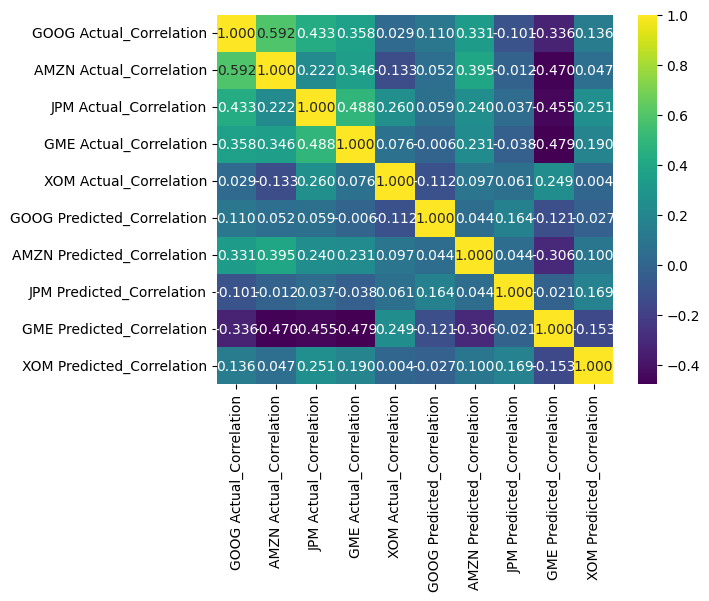

In [36]:
sns.heatmap(result_df.corr(), cmap='viridis', annot=True, fmt=".3f")

In [37]:
for stock in stock_list[:-1]:
  print(f"【{stock}】Mean Squared Error (MSE):", ((result_df[stock + ' Predicted_Correlation'] - result_df[stock + ' Actual_Correlation']) ** 2).mean())

【GOOG】Mean Squared Error (MSE): 0.022463664
【AMZN】Mean Squared Error (MSE): 0.025668599
【JPM】Mean Squared Error (MSE): 0.039018802
【GME】Mean Squared Error (MSE): 0.1673923
【XOM】Mean Squared Error (MSE): 0.075093
